# Weighted Estimation for Stock Price
# First Step: Import Data

In [7]:
#Initialization

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [8]:
import fix_yahoo_finance as yf  


Stocks = ['AAPL', 'FB','GOOGL','AMZN']
data = yf.download(Stocks,'2016-01-01','2018-06-01')

[*********************100%***********************]  4 of 4 downloaded


In [9]:
data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 608 (major_axis) x 4 (minor_axis)
Items axis: Open to Volume
Major_axis axis: 2016-01-04 00:00:00 to 2018-06-01 00:00:00
Minor_axis axis: AAPL to GOOGL

# Second Step: Amazon stock price

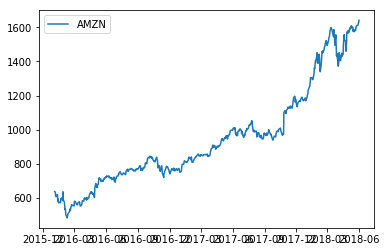

In [20]:
St = data['Adj Close']['AMZN']
plt.plot(St)
plt.legend(['AMZN'])

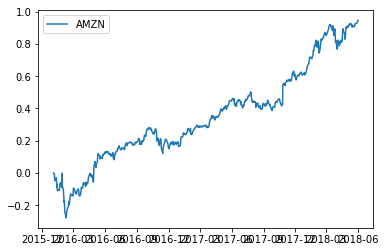

In [23]:
# Take the log price
LogSt = np.log(St) - np.log(St[0])
plt.plot(LogSt)
plt.legend(['AMZN'])


# Third Step: Prediction of different models

N-day return estimation




In [66]:
N_day = 30
T = len(St)
S_nd = np.zeros(T-N_day)
for t in range(N_day,T):
    S_nd[t-N_day] = (LogSt[t] - LogSt[t-N_day])/N_day + LogSt[t]


Mean reversion - OU model

In [67]:
S_ou = np.zeros(T-N_day)
for t in range(N_day,T):
    train = np.array(LogSt[t-N_day:t])
    #fit linear regression
    y = train[1:] - train[:-1]
    x = train[:-1]
    param = np.polyfit(x,y,1)
    beta = -param[0]
    mu = param[1]/beta
    dx = beta*(mu - train[-1])
    S_ou[t-N_day] = LogSt[t] + dx



AR and MA

In [142]:
import statsmodels.tsa.ar_model as ARM
import warnings



warnings.simplefilter("ignore")


daily_close=LogSt


# Moving average 
MA=daily_close.rolling(window=N_day+1,center=False).mean()
MA.columns=['MA']

# AutoRegression
X = LogSt

AR = pd.DataFrame([['NaN']]*N_day,columns=['AR'])
AR.index=X.index[0:N_day]
for i in range(len(X)-N_day):
    train=X[i:i+N_day]
    test=X[N_day]
    model = ARM.AR(train)
    model_fit = model.fit()
    s=pd.Series.to_frame(model_fit.predict(start=len(train),end=len(train)))
    s.columns=['AR']
    s.index=X.index[i+N_day:i+N_day+1]
    AR=AR.append(s)
    
#AR=pd.Series(AR)    
S_ma = np.array(MA)
S_ar = np.array(AR)

In [141]:
AR=pd.Series(AR) 
AR

0      (A, R)
1      (A, R)
2      (A, R)
3      (A, R)
4      (A, R)
5      (A, R)
6      (A, R)
7      (A, R)
8      (A, R)
9      (A, R)
10     (A, R)
11     (A, R)
12     (A, R)
13     (A, R)
14     (A, R)
15     (A, R)
16     (A, R)
17     (A, R)
18     (A, R)
19     (A, R)
20     (A, R)
21     (A, R)
22     (A, R)
23     (A, R)
24     (A, R)
25     (A, R)
26     (A, R)
27     (A, R)
28     (A, R)
29     (A, R)
        ...  
578    (A, R)
579    (A, R)
580    (A, R)
581    (A, R)
582    (A, R)
583    (A, R)
584    (A, R)
585    (A, R)
586    (A, R)
587    (A, R)
588    (A, R)
589    (A, R)
590    (A, R)
591    (A, R)
592    (A, R)
593    (A, R)
594    (A, R)
595    (A, R)
596    (A, R)
597    (A, R)
598    (A, R)
599    (A, R)
600    (A, R)
601    (A, R)
602    (A, R)
603    (A, R)
604    (A, R)
605    (A, R)
606    (A, R)
607    (A, R)
Length: 608, dtype: object

In [81]:
Strategy=pd.concat([MA,AR,daily_close],axis=1)
plt.plot(Strategy[N_day:])
plt.legend(['AR','MA','AMZN'])
plt.show()

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

plot prediction

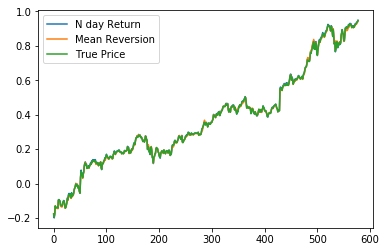

In [68]:
plt.plot(S_nd)
plt.plot(S_ou)
plt.plot(np.array(LogSt[N_day:]))
plt.legend(['N day Return', 'Mean Reversion', 'True Price'])

Plot deviation from true price

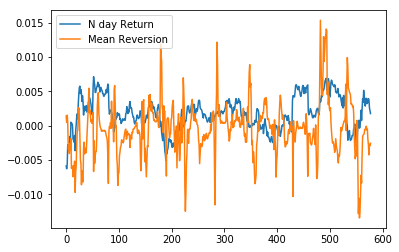

In [69]:
plt.plot(S_nd-np.array(LogSt[N_day:]))
plt.plot(S_ou-np.array(LogSt[N_day:]))
plt.legend(['N day Return', 'Mean Reversion'])


# Weighted Estimation Based on Regret

Average regret of Weighted Estimation is nan
Average regret of N day Return is 153903.998427
Average regret of Mean Reversion is 162898.70853442026


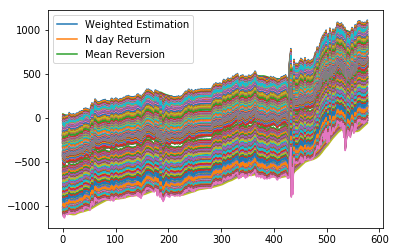

In [120]:
WEst = np.zeros(T)
reg_nd = [0]
reg_ou = [0]
for t in range(N_day,T):
    w_nd = np.exp(-reg_nd[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0]))
    w_ou = np.exp(-reg_ou[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0]))
    WEst[t] = w_nd*MA[t] + w_ou*AR[t]
    #use square loss as the regret
    reg_nd += (MA[t] - X[t])**2
    reg_ou += (AR[t] - X[t])**2

plt.plot(WEst[N_day:]-np.array(X[N_day:]))
plt.plot(MA[N_day:]-np.array(X[N_day:]))
plt.plot(AR[N_day:]-np.array(X[N_day:]))
plt.legend(['Weighted Estimation', 'N day Return', 'Mean Reversion'])

print('Average regret of Weighted Estimation is',np.mean(np.power(WEst[N_day:]-np.array(X[N_day:]),2)))
print('Average regret of N day Return is',np.mean(np.power(MA[N_day:]-np.array(X[N_day:]),2)))
print('Average regret of Mean Reversion is',np.mean(np.power(AR[N_day:]-np.array(X[N_day:]),2)))

In [126]:
MA

array([[           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [  569.13838548],
       [  565.52580516],
       [  562.33580665],
       [  559.97612845],
       [  558.2019349 ],
       [  556.49193458],
       [  554.47290342],
       [  552.45161197],
       [  551.50677397],
       [  551.05645068],


In [106]:
np.power(WEst-np.array(LogSt[N_day:]),2)

ValueError: operands could not be broadcast together with shapes (608,) (578,) 

In [107]:
WEst-np.array(LogSt[N_day:])

ValueError: operands could not be broadcast together with shapes (608,) (578,) 

AttributeError: 'float' object has no attribute 'exp'

In [97]:
np.exp(-reg_nd)

array([ 0.])

In [103]:
 reg_ou[0]

281333.55823366105